# Exploring CMH Parking Violations

## Imports

* pandas
* string
    * parse string amounts to translate into floats

In [269]:
# Edit notebook in external editor, so don't auto-save from jupyter notebook
%autosave 0

Autosave disabled


In [270]:
#%matplotlib inline

import datetime
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
import networkx as nx


## Loading data

### Violations

[Columbus City Parking Violations and Ticket Status 2013-2018 -- COLUEXTRACT](
https://discovery.smartcolumbusos.com/dataset/conduent/160c98a1_ad56_4658_8553_5ee8e7d0d953) - Smart Columbus

This dataset covers the parking violations identified by Parking Enforcement Officer (PEO) and the tickets issued
for those violations. Also, the data identifies the status of the ticket (e.g., paid, dismissed, etc.,)
This dataset covers years 2013 through 2018.

In [271]:
violations = pd.read_csv("../data/raw/160c98a1-ad56-4658-8553-5ee8e7d0d953.csv.gz",
                              compression='gzip',
                              low_memory=False)

In [272]:
pd.set_option('display.max_columns', None)
violations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Data columns (total 98 columns):
nix dt        745821 non-null int64
hrg offcr     27951 non-null object
dispo         745821 non-null int64
badge         733375 non-null object
susp til      745821 non-null int64
mail1 dt      745821 non-null int64
iss dt        745821 non-null int64
ent due       745821 non-null object
viol          745821 non-null int64
ipp no        745821 non-null int64
mail2 dt      745821 non-null int64
conf dt2      745821 non-null int64
fine          745821 non-null object
coll dt       745821 non-null int64
pen4          745821 non-null object
corro         745821 non-null int64
last seiz     745821 non-null int64
hear proc     745821 non-null int64
dis dt        745821 non-null int64
mail1 pdt     745821 non-null int64
bootbl ct     745821 non-null int64
ticket        745821 non-null object
entity        745821 non-null int64
plea          0 non-null float64
multno        745821 no

### Dictionary for parking violations
An explanation of all the fields in the violations dataset


In [273]:
violations_dictionary = pd.read_json(
    "https://data.smartcolumbusos.com/api/v1/dataset/160c98a1-ad56-4658-8553-5ee8e7d0d953/dictionary")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', -1)
violations_dictionary.head(98)

type        name  \
0   integer  ENTITY       
1   integer  TERMDT       
2   integer  MULTNO       
3   string   ENT DUE      
4   string   ENT OVP      
5   integer  CONF DT      
6   integer  HOLD CT      
7   integer  LAST SEIZ    
8   string   SEIZ STAT    
9   integer  SEIZ DT      
10  integer  NIX DT       
11  string   NIX STAT     
12  integer  BOOTBL CT    
13  integer  SEIZBL CT    
14  string   EXCLUDE      
15  string   TICKET       
16  string   DUE          
17  integer  PLT YR       
18  integer  PLT EXP      
19  string   TICK TYP     
20  string   BOOT IND     
21  string   SEIZ IND     
22  string   OVERPD       
23  integer  HOLD RQ DT   
24  string   COLL AGCY    
25  integer  COLL DT      
26  integer  ISS DT       
27  string   BADGE        
28  integer  ISS AGCY     
29  integer  DIV          
30  integer  VIOL         
31  string   FINE         
32  string   LOCATION     
33  string   ROUTE        
34  string   MAKE         
35  integer  ISS TIME     
36  integer  TIME2        
37  string   METER        
38  integer  LOAD DT      
39  integer  BATCH        
40  integer  BATCH DT     
41  string   PEN1         
42  string   PEN2         
43  string   PEN3         
44  string   PEN4         
45  string   PEN5         
46  integer  CONF DT2     
47  integer  NIXTK DT     
48  string   NIXTK STAT   
49  string   HOLD STAT    
50  integer  HOLD DATE    
51  integer  PAY TYPE     
52  integer  DEPOSIT DT   
53  string   PAY AMT      
54  integer  PAY METH     
55  integer  PAY PRC DT   
56  integer  PAY BATCH    
57  string   MORE PAYS    
58  integer  PAY SRC      
59  integer  MAIL1 TY     
60  integer  MAIL1 DT     
61  integer  MAIL1 PDT    
62  integer  MAIL2 TY     
63  integer  MAIL2 DT     
64  integer  MAIL2 PDT    
65  integer  MAIL3 TY     
66  integer  MAIL3 DT     
67  integer  MAIL3 PDT    
68  integer  MAIL4 TY     
69  integer  MAIL4 DT     
70  integer  MAIL4 PDT    
71  integer  MAIL5 TY     
72  integer  MAIL5 DT     
73  integer  MAIL5 PDT    
74  string   MORE MAIL    
75  integer  SUSP TIL     
76  integer  SUSP CODE    
77  integer  SUSP DT      
78  string   MORE SUSP    
79  integer  HEAR DT      
80  integer  HEAR TM      
81  integer  HEAR PROC    
82  string   PLEA         
83  string   RED          
84  integer  DISPO        
85  integer  DIS DT       
86  integer  DIS PDT      
87  string   MORE HEAR    
88  string   HRG OFFCR    
89  integer  CORRO        
90  integer  COR DT       
91  string   MORE CORR    
92  string   NAME REAS    
93  integer  LAT          
94  integer  LONG         
95  integer  OPEN CT      
96  integer  IPP NO       
97  string   IPP STAT     

                                                                                                                                           description  
0   Unique system-generated number to identify license plate-based accounts                                                                             
1   If a license plate was on a fleet and terminated, this would record the date on which the plate was terminated from the fleet. Julian date format.  
2   If a license plate was on a fleet, that fleet is identified with this number                                                                        
3   Total amount due on the entity                                                                                                                      
4   Overpaid amount on the entity                                                                                                                       
5   Date on which the BMV/Registry returned registered owner name and address information                                                               
6   Total number of tickets on the entity on registration hold                                                                                          
7   Date on which the vehicle was last seized                                                                

### Meters


Meters is a dataset that contains the location of every meter in Columbus.  The Violations dataset reports the
meter where a violation was issued, but the location is often missing, and even when it's there it's location
doesn't precisely match that of the meter for which the violation was issued.  I suspect this is because the
location is based on where the the Agent (or their hand-held device) when the data was transmitted.

Thankfully the meter number is present in the Violations dataset, so we can join the Violations and Meters dataset
to get the location of the meter for which a violation was issued.

In [274]:
meters = pd.read_csv("../data/raw/d9b11b8f-67f3-48c4-8831-0f22d93166ce")

## Extract interesting data from Violations dataset

In [275]:
# work with the most promising columns:
violations_columns_use = ['ticket', 'entity', 'meter', 'iss dt', 'due', 'fine', 'make', 'iss time',
                            'badge', 'pay amt', 'lat', 'long']

In [276]:
# extract date-related fields
violations['issue_date'] = violations['iss dt'].map(lambda dt: datetime.datetime.strptime(str(dt), '%Y%j'))
violations['year'] = violations['issue_date'].map(lambda dt: dt.year)
violations['dayOfWeek'] = violations['issue_date'].map(lambda dt: dt.weekday())
import numpy as np
violations['hour'] = np.floor(violations['iss time'] / 100)

In [277]:
# convert 'pay amt' and 'fine' into float datatype
trans_dict ={ord('$'): None, ord('('): None, ord(')'): None, ord(","): None}
violations['amt_float'] = violations['pay amt'].str.translate(trans_dict).astype(float)
violations['fine_float'] = violations['fine'].str.translate(trans_dict).astype(float)

In [278]:
# let's see the data
computed_columns = ['issue_date', 'year', 'dayOfWeek', 'hour', 'amt_float', 'fine_float']
violations[violations_columns_use + computed_columns].head(10)

ticket   entity  meter   iss dt     due    fine  make  iss time badge  \
0  5565039450  3487595  F48    2015205  $0.00   $30.00  DODG  2035      17     
1  5564345326  3453663  NaN    2015044  $0.00   $55.00  CHEV  1110      16     
2  5566101825  3376679  NaN    2016154  $0.00   $50.00  TOYT  2049      13     
3  5564388332  3403466  WN11   2015055  $0.00   $30.00  HOND  1010      8      
4  5565398944  3404432  NaN    2015311  $0.00   $55.00  MERC  936       10     
5  5564552703  3403466  WN106  2015072  $0.00   $30.00  HOND  1608      20     
6  5564385856  3402536  K332   2015050  $0.00   $30.00  FORD  1427      9      
7  5594213232  3406864  NaN    2014210  $15.00  $50.00  HYUN  1640      1843   
8  5562730846  3166187  NK265  2014044  $85.00  $50.00  CHEV  1621      19     
9  5595457961  3406828  NaN    2014209  $0.00   $25.00  DODG  1024      NaN    

  pay amt  lat  long issue_date  year  dayOfWeek  hour  amt_float  fine_float  
0  $30.00  0    0    2015-07-24  2015  4          20.0  30.0       30.0        
1  $90.00  0    0    2015-02-13  2015  4          11.0  90.0       55.0        
2  $65.00  0    0    2016-06-02  2016  3          20.0  65.0       50.0        
3  $45.00  0    0    2015-02-24  2015  1          10.0  45.0       30.0        
4  $70.00  0    0    2015-11-07  2015  5          9.0   70.0       55.0        
5  $45.00  0    0    2015-03-13  2015  4          16.0  45.0       30.0        
6  $30.00  0    0    2015-02-19  2015  3          14.0  30.0       30.0        
7  $50.00  0    0    2014-07-29  2014  1          16.0  50.0       50.0        
8  $0.00   0    0    2014-02-13  2014  3          16.0  0.0        50.0        
9  $25.00  0    0    2014-07-28  2014  0          10.0  25.0       25.0

In [279]:
# date columns
violations[['iss dt', 'iss time', 'issue_date', 'year', 'dayOfWeek', 'hour' ]]

iss dt  iss time issue_date  year  dayOfWeek  hour
0       2015205  2035     2015-07-24  2015  4          20.0
1       2015044  1110     2015-02-13  2015  4          11.0
2       2016154  2049     2016-06-02  2016  3          20.0
3       2015055  1010     2015-02-24  2015  1          10.0
4       2015311  936      2015-11-07  2015  5          9.0 
...         ...  ...             ...   ... ..          ... 
745816  2013146  1605     2013-05-26  2013  6          16.0
745817  2013186  919      2013-07-05  2013  4          9.0 
745818  2013141  1657     2013-05-21  2013  1          16.0
745819  2013163  2249     2013-06-12  2013  2          22.0
745820  2013144  1819     2013-05-24  2013  4          18.0

[745821 rows x 6 columns]

## About fines

#### Show distribution of fine and pay_amt

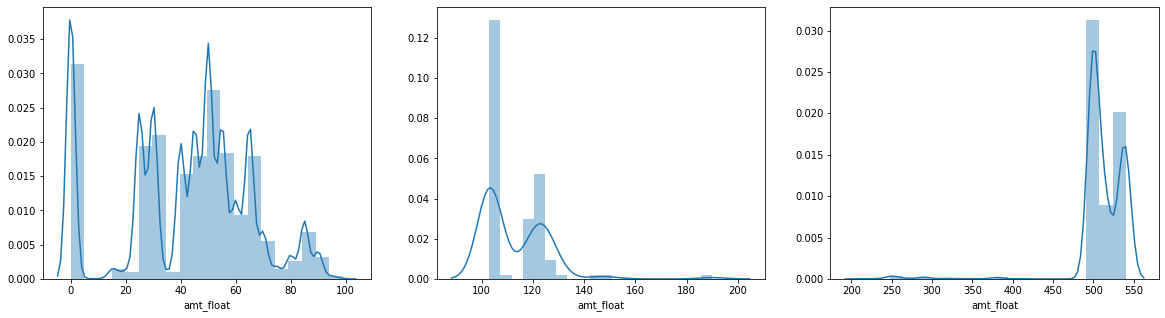

In [280]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
sns.distplot(violations[violations['amt_float'] < 100]['amt_float'], bins=20, ax=ax1)
sns.distplot(violations[(violations['amt_float'] > 100) & (violations['amt_float'] <= 200)]['amt_float'], bins=20,
             ax=ax2)
sns.distplot(violations[(violations['amt_float'] > 200) & (violations['amt_float'] <= 600)]['amt_float'], bins=20,
             ax=ax3)

In [281]:
larger_amt = violations[(violations['amt_float'] >= 600)]
larger_amt

nix dt hrg offcr  dispo badge  susp til  mail1 dt   iss dt ent due  \
640038  0       NaN       0      13    0         2016131   2016099  $15.00   

        viol  ipp no  mail2 dt  conf dt2    fine  coll dt   pen4  corro  \
640038  14    0       0         2016118   $55.00  0        $0.00  0       

        last seiz  hear proc  dis dt  mail1 pdt  bootbl ct      ticket  \
640038  0          0          0       2016126    0          5565922485   

         entity  plea  multno tick typ  seiz dt    red  conf dt meter  \
640038  3542570 NaN    0       NaN      0        $0.00  2016118  NaN    

        susp code   pen2  mail4 ty  mail4 dt coll agcy    pen1  plt yr  \
640038  0          $0.00  0         0         NaN       $15.00  17       

        hold rq dt route  lat  plt exp  load dt  mail1 ty seiz stat  \
640038  0           PVB   0    2017011  2016099  1         NaN        

        pay prc dt  long  hear tm  pay batch      pay amt   pen3  mail5 ty  \
640038  2016132     0     0        85         ($5,445.00)  $0.00  0          

        nix stat ent ovp  mail2 pdt  nixtk dt  more susp  mail2 ty  \
640038 NaN        $0.00   0          0        NaN         0          

                     location  mail5 pdt  deposit dt  nixtk stat  seizbl ct  \
640038  AF 2854 INDIANOLA AVE  0          2016132    NaN          0           

        time2  iss agcy  hold date  batch dt boot ind  termdt   pen5  \
640038  0      0         0          2016100   NaN      0       $0.00   

        mail5 dt  make     due  hold ct name reas  hear dt  cor dt  iss time  \
640038  0         CHEV  $15.00  0        R         0        0       1643       

        open ct exclude  mail3 ty  pay type  dis pdt  pay meth  susp dt  \
640038  1        NaN     0         2         0        2         0         

        hold stat  div  mail3 dt  mail4 pdt overpd  pay src more mail  \
640038 NaN         0.0  0         0          $0.00  1        NaN        

       more corr  mail3 pdt  ipp stat  batch more pays seiz ind more hear  \
640038  NaN       0         NaN        201    Y         NaN      NaN        

       issue_date  year  dayOfWeek  hour  amt_float  fine_float  
640038 2016-04-08  2016  4          16.0  5445.0     55.0

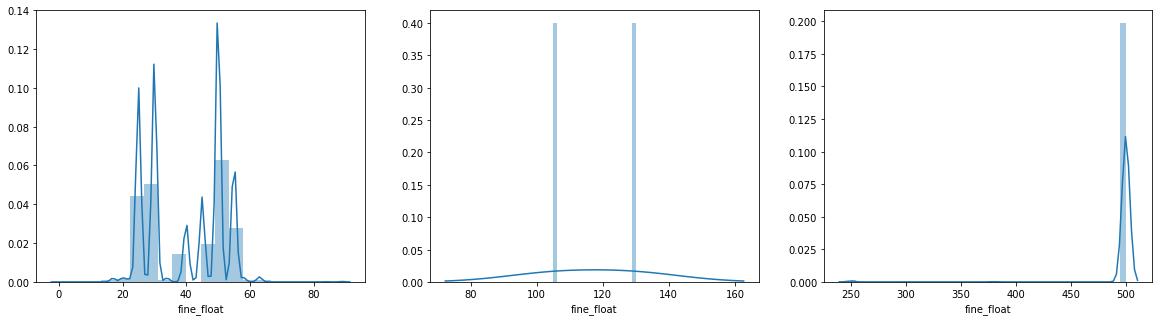

In [282]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=False, figsize=(20, 5))

sns.distplot(violations[violations['fine_float'] < 100]['fine_float'], bins=20, ax=ax1)
sns.distplot(violations[(violations['fine_float'] >= 100) & (violations['fine_float'] < 200)]['fine_float'], bins=20,
             ax=ax2)
sns.distplot(violations[(violations['fine_float'] >= 200) & (violations['fine_float'] < 600)]['fine_float'], ax=ax3)

In [283]:
violations.info()

# note that the data below doesn't show correctly on GitHub, but looks fine in the notebook
violations.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Columns: 104 entries, nix dt to fine_float
dtypes: datetime64[ns](1), float64(10), int64(63), object(30)
memory usage: 591.8+ MB


nix dt hrg offcr  dispo badge  susp til  mail1 dt   iss dt  ent due  \
341897  0        NaN       0      10    0         2017206   2017178  $0.00     
352707  0        NaN       0      18    0         0         2017292  $0.00     
409133  0        NaN       0      18    0         0         2014191  $0.00     
627911  0        NaN       0      8     0         2016117   2016088  $150.00   
327158  0        NaN       0      5     0         0         2013264  $0.00     
300428  0        NaN       0      19    0         0         2014363  $0.00     
130711  0        NaN       0      20    0         0         2018109  $0.00     
607862  0        NaN       0      2     0         0         2016050  $0.00     
644833  0        NaN       0      5     0         0         2015245  $0.00     
401518  2014203  NaN       0      19    0         0         2014003  $25.00    

        viol  ipp no  mail2 dt  conf dt2    fine  coll dt   pen4  corro  \
341897  47    0       0         2017200   $55.00  0        $0.00  0       
352707  25    0       0         0         $63.00  0        $0.00  0       
409133  26    0       0         0         $40.00  0        $0.00  0       
627911  29    0       2016159   2016104   $30.00  2017323  $0.00  0       
327158  26    0       0         0         $40.00  0        $0.00  0       
300428  29    0       0         0         $25.00  0        $0.00  0       
130711  26    0       0         0         $50.00  0        $0.00  0       
607862  13    0       0         0         $55.00  0        $0.00  0       
644833  29    0       0         0         $30.00  0        $0.00  0       
401518  72    0       0         0         $45.00  0        $0.00  0       

        last seiz  hear proc  dis dt  mail1 pdt  bootbl ct      ticket  \
341897  0          0          0       2017201    0          5567353941   
352707  2017294    0          0       0          0          5567714334   
409133  0          0          0       0          0          5563268391   
627911  0          0          0       2016112    2          5565802402   
327158  0          0          0       0          0          5562172386   
300428  0          0          0       0          0          5564226886   
130711  0          0          0       0          0          5568425770   
607862  0          0          0       0          0          5565677496   
644833  0          0          0       0          0          5564389706   
401518  0          0          0       0          0          5562618242   

         entity  plea  multno tick typ  seiz dt    red  conf dt  meter  \
341897  3575375 NaN    0       NaN      0        $0.00  2017200  NaN     
352707  3544681 NaN    0       NaN      2017294  $0.00  0        NaN     
409133  3356907 NaN    0       NaN      0        $0.00  0        K394    
627911  3427299 NaN    0       NaN      0        $0.00  2016251  SI503   
327158  3335434 NaN    0       NaN      0        $0.00  0        NaN     
300428  3430022 NaN    0       NaN      0        $0.00  2014323  UW613   
130711  3690647 NaN    0       NaN      0        $0.00  0        NaN     
607862  3531602 NaN    0       NaN      0        $0.00  0        NaN     
644833  3476083 NaN    0       NaN      0        $0.00  2017013  NO301   
401518  3345000 NaN    0       NaN      0        $0.00  2016363  K172    

        susp code    pen2  mail4 ty  mail4 dt coll agcy    pen1  plt yr  \
341897  0          $20.00  0         0         NaN       $15.00  18       
352707  0          $0.00   0         0         NaN       $0.00   17       
409133  0          $0.00   0         0         NaN       $0.00   15       
627911  0          $20.00  5         2017229   ALB       $15.00  16       
327158  0          $0.00   0         0         NaN       $0.00   13       
300428  0          $0.00   0         0         NaN       $0.00   15       
130711  0          $0.00   0         0         NaN       $0.00   19       
607862  0          $0.00   0         0         NaN       $15.00  16     

In [284]:
# distribution of outliers - entities who got more than 25 tickets
entity_tickets = violations[['entity', 'amt_float', 'fine_float']].groupby('entity').agg(['count', 'sum']).sort_values(
    [('amt_float', 'count')], ascending=False)
print(entity_tickets.head(25))

        amt_float         fine_float        
            count     sum      count     sum
entity                                      
3306104  171       5965.0  171        4900.0
3172961  149       6110.0  149        4415.0
3118181  141       5990.0  141        4355.0
2954098  107       3530.0  107        3125.0
3177010  100       3315.0  100        2830.0
3310867  96        4427.0  96         2892.0
3190248  93        3515.0  93         2960.0
3369215  88        3775.0  88         2485.0
3373505  83        3625.0  83         2545.0
3577369  82        3195.0  82         2460.0
3044891  82        3095.0  82         2165.0
3474796  81        3060.0  81         2490.0
3307004  81        3815.0  81         2635.0
3020192  79        2845.0  79         2480.0
3341297  77        3405.0  77         2320.0
3244622  77        3305.0  77         2190.0
3132197  75        3230.0  75         2225.0
2857433  74        2675.0  74         2055.0
3223602  73        2755.0  73         2085.0
2900185  7

#### distribution of fines

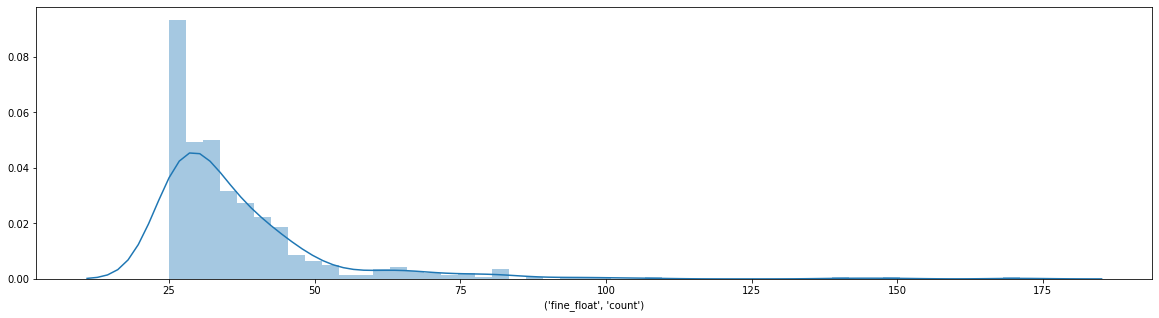

In [285]:
f, ax1 = plt.subplots(1, 1, sharex=False, figsize=(20, 5))
sns.distplot(entity_tickets[('fine_float', 'count')] \
                 [(entity_tickets[('fine_float', 'count')] >= 25)], bins=50, ax=ax1)

In [286]:
# wonder why number of violations issued went down the last three years?
violations['year'].value_counts()

2014    158001
2013    157787
2015    141000
2016    137000
2017    119000
2018    33033 
Name: year, dtype: int64

#### Distribution of fines by day of the week

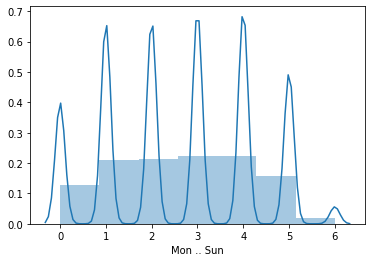

In [287]:
# Monday and Sunday are lighter days for parking tickets
sns.distplot(violations['dayOfWeek'], bins=7, axlabel="Mon .. Sun")

#### Distribution of fines by time of the day

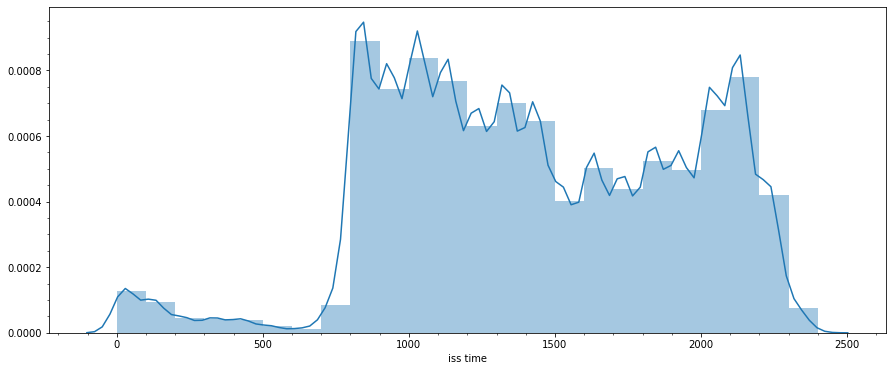

In [288]:
plt.figure(figsize=(15, 6))
ax = sns.distplot(violations['iss time'], bins=24, norm_hist=True, )
ax.minorticks_on()

#### All about agents (as identified by badge) who gave most tickets

In [289]:
print(violations[['badge']].describe())
agent_business = violations[['badge', 'year', 'entity', 'ticket', 'fine_float']] \
    .groupby(['badge', 'year']) \
    .agg({'fine_float': ['mean', 'min', 'max'], 'entity': ['count']})

agent_business.columns = ['fine_mean', 'fine_min', 'fine_max', 'entity_count']
agent_business.reset_index().sort_values('entity_count', ascending=False).head(25)

         badge
count   733375
unique  2051  
top     13    
freq    73110 


badge  year  fine_mean  fine_min  fine_max  entity_count
1848  19    2013  35.593301  17.0      500.0     24003       
408   13    2015  42.127513  25.0      500.0     18202       
1849  19    2014  34.760192  17.0      500.0     18127       
2026  20    2015  43.643559  25.0      500.0     17498       
407   13    2014  35.339367  20.0      500.0     16684       
409   13    2016  43.338548  22.0      500.0     16683       
2027  20    2016  45.177827  22.0      500.0     15695       
410   13    2017  44.916014  25.0      500.0     14693       
7     10    2014  41.541395  17.0      500.0     13214       
6     10    2013  42.017471  17.0      500.0     12936       
1285  17    2016  41.411556  22.0      500.0     12375       
1284  17    2015  40.895726  22.0      500.0     12026       
9     10    2016  48.771174  22.0      500.0     11878       
8     10    2015  48.037226  22.0      500.0     11739       
6479  7     2014  38.731016  17.0      500.0     11220       
10    10    2017  50.387137  22.0      500.0     11133       
1547  18    2017  42.603935  22.0      500.0     11079       
6478  7     2013  37.229738  17.0      500.0     10969       
6480  7     2015  47.053724  17.0      500.0     10796       
794   15    2015  47.147782  20.0      500.0     10414       
1282  17    2013  36.032942  17.0      500.0     10230       
6481  7     2016  47.552160  22.0      500.0     9979        
2025  20    2014  34.392635  20.0      500.0     9640        
1283  17    2014  35.092407  20.0      500.0     9588        
6482  7     2017  47.763348  22.0      500.0     9533

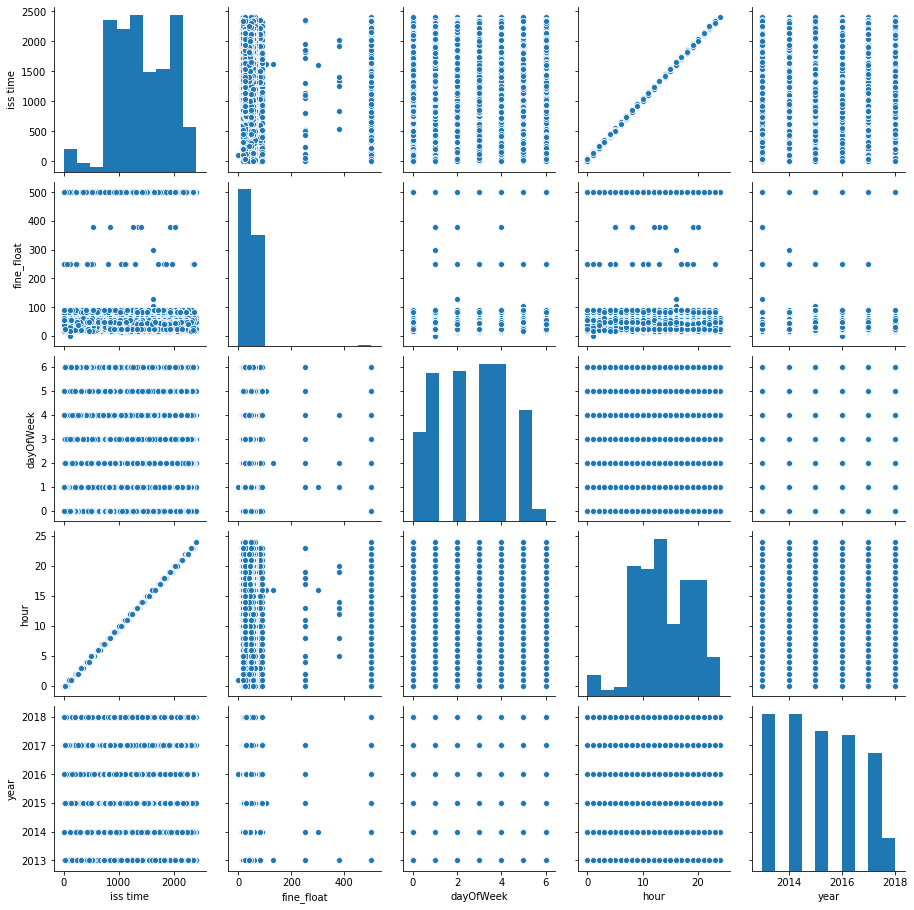

In [290]:
violations_clean = violations[['iss time', 'fine_float', 'dayOfWeek', 'hour', 'year']].dropna()
#sns.pairplot(violations_clean)

#### How many tickets are generally given each day?

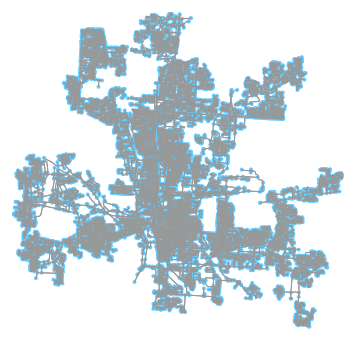

In [291]:
# get network graph for Columbus from disk if available (much faster to load)
try:
    G = ox.load_graphml('cmh_network.graphml')
except IOError:
    print("Download and save network.")
    G = ox.graph_from_place('Columbus, Ohio, USA', network_type='drive', simplify=False)
    ox.save_graphml(G, filename='cmh_network.graphml')
    G = ox.load_graphml('cmh_network.graphml')

fig, ax = ox.plot_graph(G)

In [292]:
# get min, max for lat long as coordinates from G, to get bounds
cmh_gdf = ox.graph_to_gdfs(G)
print(cmh_gdf[0].x.agg(['min', 'max']))
print(cmh_gdf[0].y.agg(['min', 'max']))

cmh_n = float(cmh_gdf[0].y.agg('max'))
cmh_s = float(cmh_gdf[0].y.agg('min'))
cmh_e = float(cmh_gdf[0].x.agg('max'))
cmh_w = float(cmh_gdf[0].x.agg('min'))

print(cmh_n, cmh_s, cmh_e, cmh_w)

min   -83.172436
max   -82.772184
Name: x, dtype: float64
min    39.860829
max    40.152758
Name: y, dtype: float64
40.1527582 39.860829 -82.7721843 -83.172436


In [293]:
# convert lat/long to usable lat/long float values
violations['lat_float'] = violations['lat'] / 1000000
violations['long_float'] = violations['long'] / 1000000 * -1

#### Exploring Meters

In [294]:
# meters

meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone            5490 non-null object
Area            5490 non-null object
Sub Area        5490 non-null object
Meter Number    5490 non-null object
ConfigId        5490 non-null int64
Lat             5490 non-null float64
Long            5490 non-null float64
Active          5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


In [295]:
# meters[meters['meter number'] == 'EN529']

meters = meters.rename(columns={'Meter Number': 'Meter'})
meters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 8 columns):
Zone        5490 non-null object
Area        5490 non-null object
Sub Area    5490 non-null object
Meter       5490 non-null object
ConfigId    5490 non-null int64
Lat         5490 non-null float64
Long        5490 non-null float64
Active      5490 non-null int64
dtypes: float64(2), int64(2), object(4)
memory usage: 343.2+ KB


### Merging violations and meters

In [345]:
violations = violations.rename(columns={'meter': 'Meter'})
violations.info()
meters_loc = meters[['Meter', 'Lat', 'Long']]

violations_x_meters = violations.merge(meters, how='left', on='Meter')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 745821 entries, 0 to 745820
Columns: 106 entries, nix dt to long_float
dtypes: datetime64[ns](1), float64(12), int64(63), object(30)
memory usage: 603.2+ MB


#### Set the violation location from the meters dataset if available

In [346]:
# TODO: make faster if possible.. vectorization?
fudge = 0.2
violations_x_meters['lat_combined'] = \
    violations_x_meters.apply(lambda p: p['Lat'] if (p['Lat'] > cmh_s - fudge) & (p['Lat'] < cmh_n + fudge) \
        else p['lat_float'], axis=1)
violations_x_meters['long_combined'] = \
    violations_x_meters.apply(lambda p: p['Long'] if (p['Long'] > cmh_w - fudge) & (p['Long'] < cmh_e + fudge) \
        else p['long_float'], axis=1)
violations_x_meters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 745821 entries, 0 to 745820
Columns: 115 entries, nix dt to long_combined
dtypes: datetime64[ns](1), float64(18), int64(63), object(33)
memory usage: 660.1+ MB


In [359]:
# only keep the records with an actual location
violations_x_meters = violations_x_meters[(violations_x_meters['lat_combined'] > 0) & (violations_x_meters['long_combined'] < 0)]
violations_x_meters.shape

(423224, 115)

#### Distribution of number of violations given per day in Columbus

            Meter
issue_date       
2013-01-01  0    
2013-01-02  354  
2013-01-03  384  
2013-01-04  379  
2013-01-05  320  
...         ...  
2018-04-17  276  
2018-04-18  275  
2018-04-19  254  
2018-04-20  257  
2018-04-21  30   

[1937 rows x 1 columns]


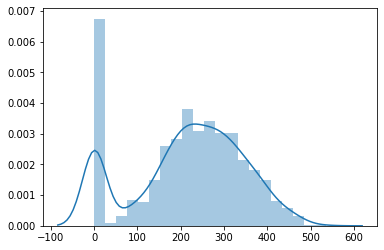

In [360]:
violations_by_day = violations[['issue_date', 'Meter']].groupby(['issue_date']).count()
sns.distplot(violations_by_day)
print(violations_by_day)

In [361]:
violations_x_meters.head(12)

nix dt hrg offcr  dispo badge  susp til  mail1 dt   iss dt  ent due  viol  \
0   0       NaN       0      17    0         0         2015205  $0.00    29     
3   0       NaN       0      8     0         2015083   2015055  $0.00    29     
5   0       NaN       0      20    0         0         2015072  $0.00    29     
6   0       NaN       0      9     0         0         2015050  $0.00    29     
8   0       NaN       0      19    0         2014070   2014044  $100.00  14     
13  0       NaN       0      19    2013044   0         2013029  $0.00    29     
18  0       NaN       0      17    0         2014126   2014100  $0.00    29     
20  0       NaN       0      10    0         2014084   2014053  $75.00   72     
21  0       NaN       0      17    0         0         2014269  $15.00   72     
22  0       NaN       0      9     0         0         2014296  $0.00    29     
25  0       NaN       0      13    2014036   0         2014011  $0.00    72     
26  0       DW        1      19    2014281   0         2014069  $85.00   29     

    ipp no  mail2 dt  conf dt2    fine  coll dt   pen4  corro  last seiz  \
0   0       0         0         $30.00  0        $0.00  0      0           
3   0       0         2015077   $30.00  0        $0.00  0      2017260     
5   0       0         0         $30.00  0        $0.00  0      2017260     
6   0       0         0         $30.00  0        $0.00  0      2016194     
8   0       2014098   2014079   $50.00  0        $0.00  0      0           
13  0       0         0         $25.00  0        $0.00  40     0           
18  0       2014168   2014120   $25.00  0        $0.00  0      0           
20  0       0         2014071   $45.00  0        $0.00  0      2014104     
21  0       0         2014289   $45.00  0        $0.00  0      0           
22  0       0         0         $25.00  0        $0.00  0      0           
25  0       0         2014029   $45.00  0        $0.00  47     0           
26  0       0         0         $25.00  0        $0.00  99     2014220     

    hear proc   dis dt  mail1 pdt  bootbl ct      ticket   entity  plea  \
0   0          0        0          0          5565039450  3487595 NaN     
3   0          0        2015078    0          5564388332  3403466 NaN     
5   0          0        0          0          5564552703  3403466 NaN     
6   0          0        0          0          5564385856  3402536 NaN     
8   0          0        2014065    0          5562730846  3166187 NaN     
13  0          0        0          0          5561280833  3280937 NaN     
18  0          0        2014121    0          5562955616  3316101 NaN     
20  0          0        2014079    0          5562769346  3271904 NaN     
21  0          0        0          0          5563634841  3426555 NaN     
22  0          0        0          0          5563824692  3428997 NaN     
25  0          0        0          0          5562646485  3360431 NaN     
26  2014261    2014261  0          0          5562843200  3370851 NaN     

    multno tick typ  seiz dt    red  conf dt  Meter  susp code    pen2  \
0   0       NaN      0        $0.00  2016125  F48    0          $0.00    
3   0       NaN      2017260  $0.00  2017228  WN11   0          $0.00    
5   0       NaN      2017260  $0.00  2017228  WN106  0          $0.00    
6   0       NaN      2016194  $0.00  0        K332   0          $0.00    
8   0       NaN      0        $0.00  2014235  NK265  0          $20.00   
13  0       NaN      0        $0.00  0        S23    40         $0.00    
18  0       NaN      0        $0.00  2015070  K651   0          $20.00   
20  0       NaN      2014106  $0.00  2014169  K70    0          $0.00    
21  0       NaN      0        $0.00  2014289  K1403  0          $0.00    
22  0       NaN      0        $0.00  0        WN5    0          $0.00    
25  0       NaN      0        $0.00  2014029  K1153  47         $0.00    
26  0       NaN      2014222  $0.00  2015147  S4     99         $0.00    

    mail4 ty  mail4 dt

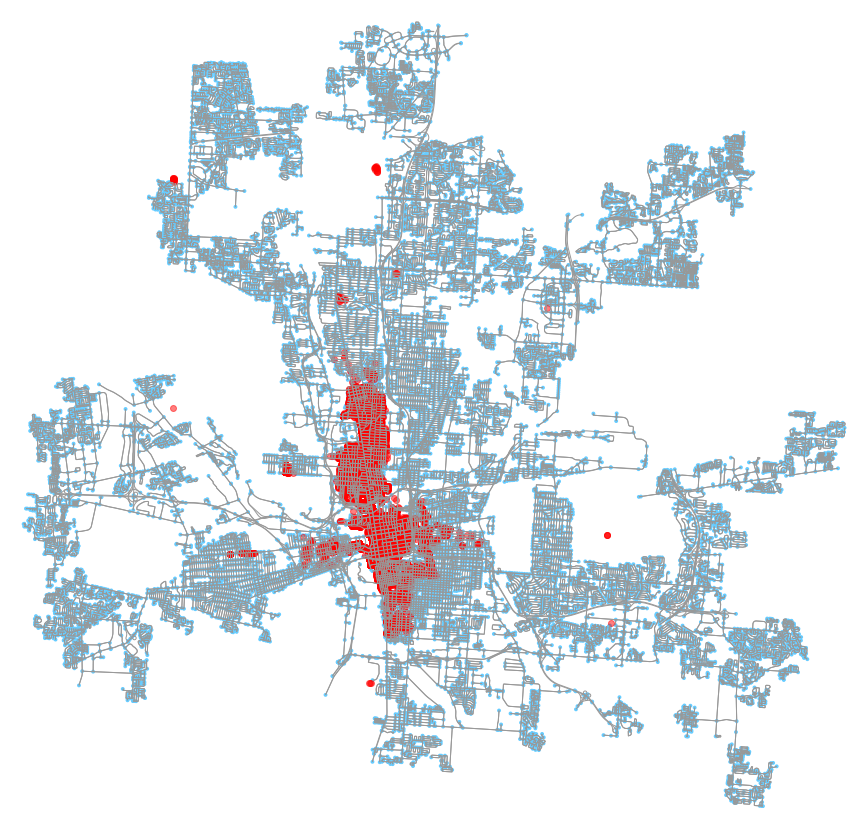

In [367]:
fig, ax = ox.plot_graph(G, fig_height=15, show=False, close=False)
ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.5, c='red')

In [489]:
heat_tickets = violations_x_meters[(violations_x_meters['badge'] == '19') & \
                                   (violations_x_meters['issue_date'] == '2014-02-13')] \
    .sort_values(by='iss time') \
    [['Meter', 'lat_combined', 'long_combined']].dropna() \
 
heat_tickets.shape

(63, 3)

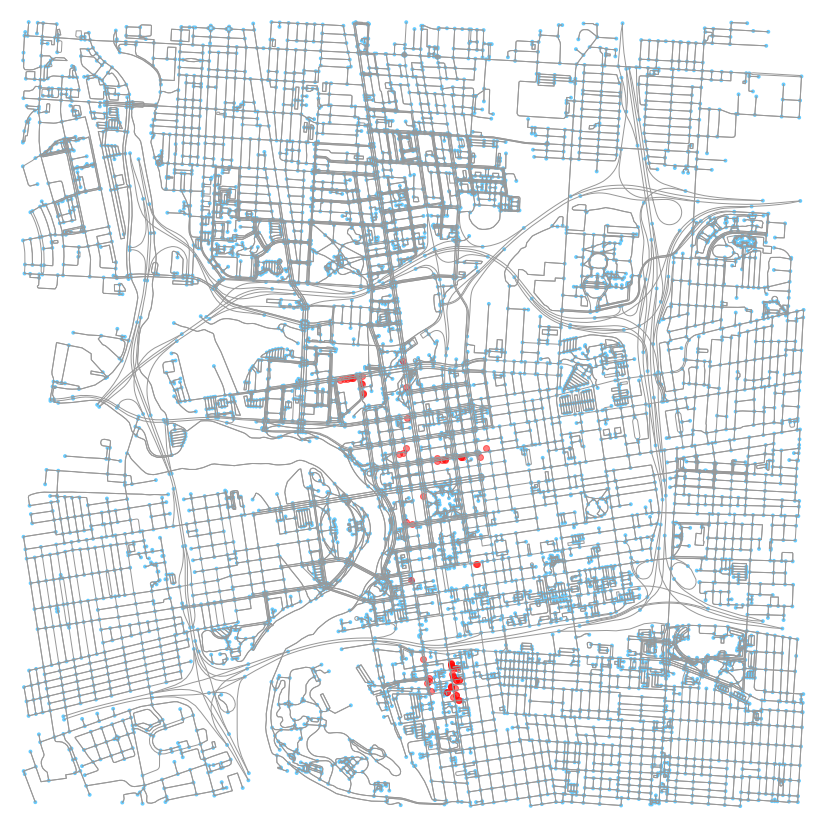

In [478]:
# Would like to create a heat map for just this area
bbox = ox.core.bbox_from_point((39.966358, -83.001397), 2500)
north, south, east, west = bbox

G_small = ox.graph_from_bbox(north, south, east, west,  simplify=True, retain_all=False)
fig, ax = ox.plot_graph(G_small, fig_height=15, show=False, close=False)
ax.scatter(heat_tickets['long_combined'], heat_tickets['lat_combined'], alpha=0.5, c='red')

In [479]:
# get nearest node to each meter location

def heat_nodes(heat_tickets):
    for ticket in heat_tickets.values:
        meter, lat, long = ticket
        yield ox.get_nearest_node(G_small, (lat, long))

In [508]:
# %load ~/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-JzEtr0-_-py3.7/lib/python3.7/site-packages/heatmapx/__init__.py
__version__ = '0.1.0'
__all__ = ['temperature_graph']

import itertools

from typing import Iterable, Optional, Union

import networkx as nx


def temperature_graph(
        G: nx.Graph,
        source_nodes: Iterable,
        depth_limit: Optional[int] = None,
        heat_increments: Union[Iterable, float] = 1,
        heat_key: str = 'heat'
) -> nx.Graph:
    """
    Calculate temperatures radiating from heat sources in a graph.

    Temperature values are initially set to 0 and then updated throughout `G` in
    a breadth-first manner beginning at each node in `source_nodes`.  For each
    source node `s`, the temperature of each edge `e` and its incident nodes in
    `G` are updated according to `heat_increments` and how many edges away they
    are from the source node `s`.  This process is repeated for every source
    node, with temperatures from multiple source nodes contibuting additively to
    the overall temperature of the nodes and edges in the graph.


    Parameters
    ----------
    G : networkx.Graph
        The graph from which to generate a heatmap.  A copy of the graph will be
        produced by default.

    source_nodes : Iterable
        The nodes serving as heat sources in `G`.

    depth_limit : Optional[int]
        The maximum number of edges away from a source node to update
        temperature values.  (Default: 0)

    heat_increments : Union[Iterable, float]
        A sequence whose `n`-th element gives, for each source node `s`, the
        amount to update the temperature of each node and edge that is `n`
        breadth-first layers away from `s`.  A constant value may also be
        provided to apply to all nodes and edges in the same connected component
        as each source node.  (Default: 1)

    heat_key : str
        The name of the node and edge attribute where temperature values will be
        stored in `T`.

    Returns
    -------
    T : networkx.Graph
        A copy of `G` in which every node and edge has its temperature stored in
        a `heat_key` attribute.
    """
    T = type(G)()
    T.add_nodes_from(G.nodes(data=True), **{heat_key: 0})
    T.add_edges_from(G.edges(data=True), **{heat_key: 0})

    try:
        heat_increments = iter(heat_increments)
    except TypeError:
        heat_increments = itertools.repeat(heat_increments)

    for source in source_nodes:
        visited_nodes = set()
        data_by_depth = itertools.islice(
            zip(_edge_bfs_by_depth(T, [source]), heat_increments),
            depth_limit)
        for edges_at_depth, heat_increment in data_by_depth:
            for edge in edges_at_depth:
                _update_edge_temperature(T, edge, heat_key, heat_increment)
                _update_node_temperatures(T, edge, heat_key, heat_increment,
                                          visited_nodes)
    return T


def _edge_bfs_by_depth(G, source_nodes, orientation=None):
    yield from _group_by_sources(
        nx.edge_bfs(G, source_nodes, orientation),
        set(source_nodes))


def _group_by_sources(edges_iterator, initial_sources):
    edges = iter(edges_iterator)

    current_group_sources = set(initial_sources)
    current_group = []

    for current_edge in edges:
        if current_edge[0] in current_group_sources:
            current_group.append(current_edge)
        else:
            yield current_group
            current_group_sources = {target for _, target, _ in current_group}
            current_group = [current_edge]

    yield current_group


def _update_edge_temperature(G, edge, heat_key, heat_increment):
    G.edges[edge][heat_key] += heat_increment


def _update_node_temperatures(G, nodes, heat_key, heat_increment, visited_nodes):
    #     print(G, nodes, heat_key, heat_increment, visited_nodes)
    for node in set(nodes[:2]).difference(visited_nodes):
        G.nodes[node][heat_key] += heat_increment
        visited_nodes.add(node)

In [518]:
%time T = temperature_graph(G_small, heat_nodes(heat_tickets), heat_increments=1, depth_limit=10)

CPU times: user 2.79 s, sys: 28.2 ms, total: 2.82 s
Wall time: 2.83 s


In [519]:
import networkx as nx

nx.set_node_attributes(T, {node: data for node, data in G.nodes(data=True)})

In [520]:
nx.set_edge_attributes(
    T, {(source, target, key): data
        for source, target, key, data
        in G_small.edges(keys=True, data=True)})

In [521]:
T.graph['crs'] = G_small.graph['crs']
T.graph['name'] = G_small.graph['name']

In [522]:
heat_node_values = [heat for (id, heat) in list(T.nodes(data='heat'))]
heat_edge_values = [heat for (source, dest, heat) in list(T.edges(data='heat'))]
print(len(heat_node_values), len(heat_edge_values))

9217 26499


In [523]:
map_heat_to_color = {
    0: "#f8f7f6", 1: "#fff5ef", 2: "#ffe7dc", 3: "#ffdac8", 4: "#ffcdb4",
    5: "#ffc0a1", 6: "#ffc0a1", 7: "#ffb38d", 8: "#ffa67a", 9: "#ff9966",
    10: "#ff8c52", 11: "#ff7f3f", 12: "#ff722b", 13: "#ff6518", 14: "#ff5804",
    15: "#ef5000", 16: "#dc4900", 17: "#c84300", 18: "#b43c00", 19: "#a13600",
    20: "#8d2f00", 21: "#7a2900", 22: "#662200", 23: "#662200", 24: "#662200"}

import math
def heat_to_color(index, max_index):
    use_index = index
    if max_index >= len(map_heat_to_color):
        reduce_ratio = len(map_heat_to_color) / (max_index + 1)
        use_index = math.floor(index * reduce_ratio)
    return map_heat_to_color[use_index]




In [524]:
%time node_heat_colors = [heat_to_color(heat, max(heat_node_values)) for heat in heat_node_values]
%time edge_heat_colors = [heat_to_color(heat, max(heat_edge_values)) for heat in heat_edge_values]
print(len(node_heat_colors), len(edge_heat_colors))

CPU times: user 1.69 s, sys: 9.15 ms, total: 1.7 s
Wall time: 1.71 s
CPU times: user 12.8 s, sys: 48.3 ms, total: 12.9 s
Wall time: 12.9 s
9217 26499


CPU times: user 3.58 s, sys: 56.8 ms, total: 3.64 s
Wall time: 3.49 s


(<Figure size 1403.32x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e6c549d0>)

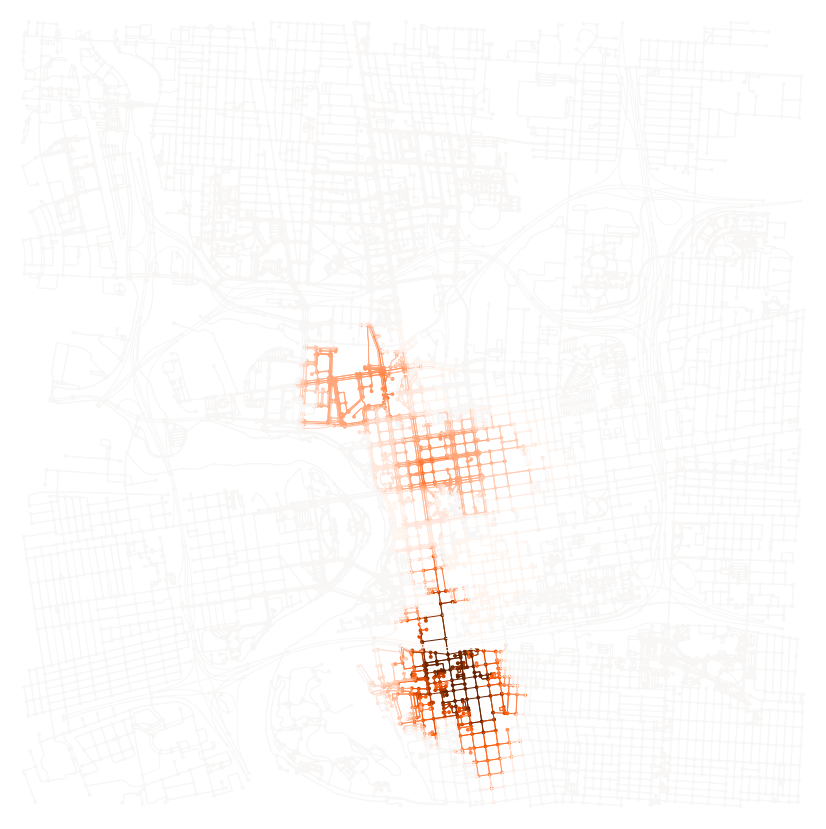

In [526]:
%time ox.plot_graph(T, fig_height=15, show=False, close=False, node_color=node_heat_colors, edge_color=edge_heat_colors)

### Plot a route from two points on the graph

In [323]:
tickets = heat_tickets
origin_point = (tickets[0:1].lat_combined.iloc[0], tickets[0:1].long_combined.iloc[0])
destination_point = (tickets[61:62].lat_combined.iloc[0], tickets[61:62].long_combined.iloc[0])

In [324]:
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
origin_node, destination_node

(229686428, 229787379)

AttributeError: 'NoneType' object has no attribute 'values'

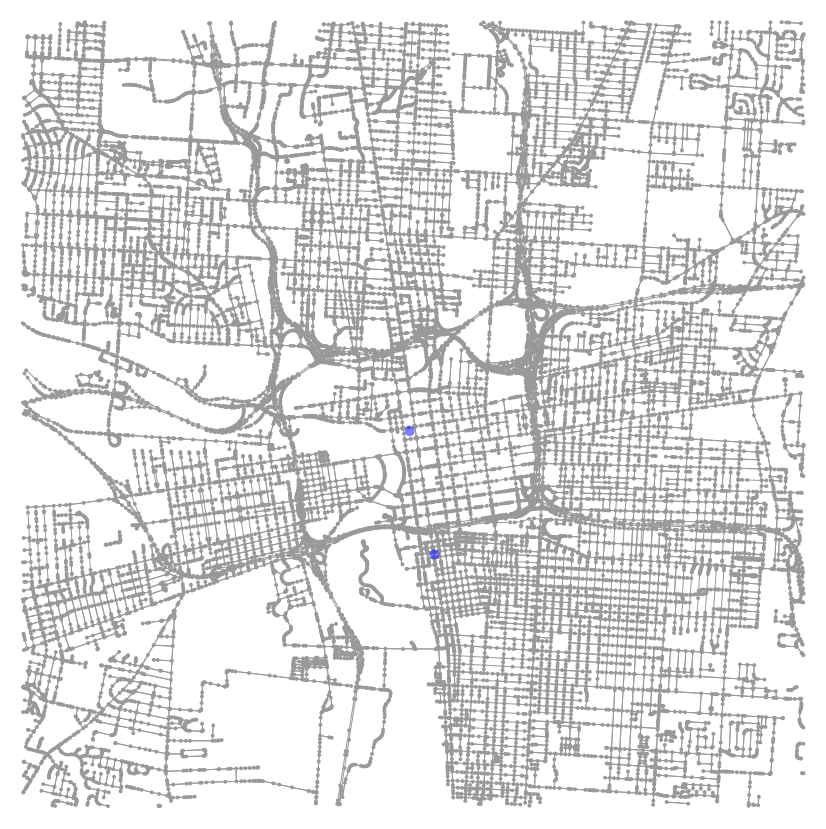

In [425]:
route = nx.shortest_path(G, origin_node, destination_node, weight='length')

# bbox = ox.core.bbox_from_point((39.966358, -83.001397), 800)
# north, south, east, west = bbox

# G_temp_small = ox.graph_from_bbox(north, south, east, west, network_type='drive', simplify=False, retain_all=True)

# when plotting a route from a bounded box it fails.. something gets extracted, but it works with full map
# projected = ox.project_graph(G_small)
fig, ax = ox.plot_graph_route(G_small, route, origin_point=origin_point,
                              destination_point=destination_point, fig_height=15, show=False, close=False)


### Color-code tickets by issuing Agent

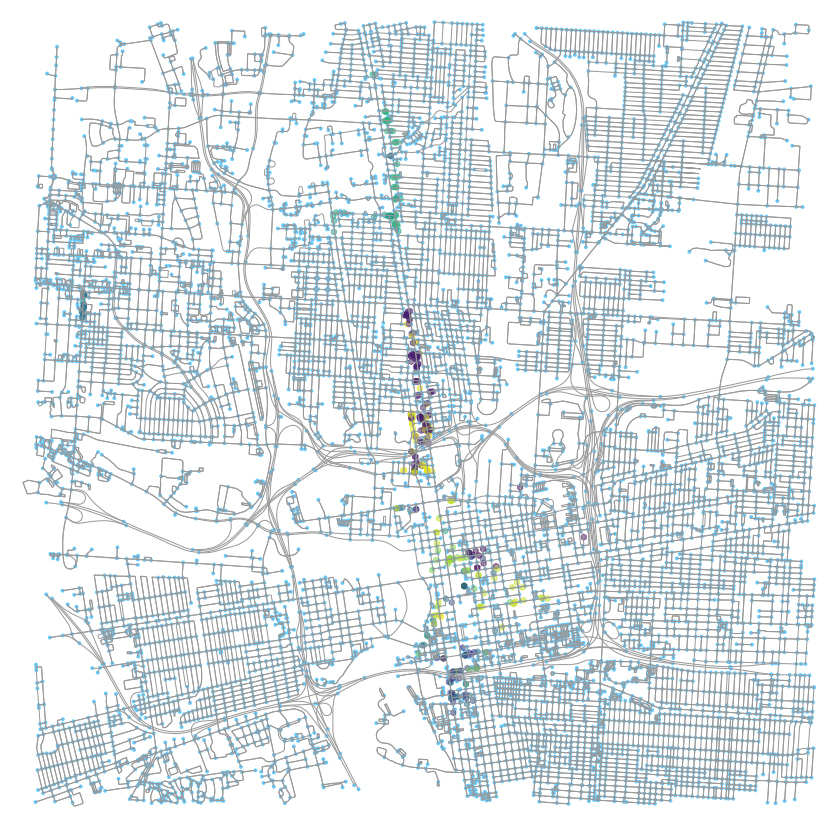

In [326]:
# 2013-01-03
violations_for_day = violations_x_meters[violations_x_meters['issue_date'] == '2013-01-03']

bbox = ox.core.bbox_from_point((39.977110, -83.003500), 4000)
north, south, east, west = bbox
G0 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')
fig, ax = ox.plot_graph(G0, fig_height=15, show=False, close=False)

import hashlib


def encode_badge(badge):
    encoded_badge = str(badge).encode('utf-8')
    return int(hashlib.sha1(encoded_badge).hexdigest(), 16) % (10 ** 8) % 10000


badge_to_colors = violations_for_day['badge'].map(encode_badge)
ax.scatter(violations_for_day['long_combined'], violations_for_day['lat_combined'], \
           alpha=0.5, c=badge_to_colors, marker='h')

In [327]:
bbox = ox.core.bbox_from_point((39.977110, -83.003500), 500)
north, south, east, west = bbox
short_north_violations = violations_x_meters[(violations_x_meters['long_combined'] < east) &
                                             (violations_x_meters['long_combined'] > west) &
                                             (violations_x_meters['lat_combined'] < north) &
                                             (violations_x_meters['lat_combined'] > south) &
                                             (violations_x_meters['year'] == 2017)
                                             ]
short_north_violations.shape
G1 = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

In [328]:
short_north_violations.shape

(11924, 115)

In [329]:
early_morning_violations = short_north_violations[(short_north_violations['iss time'] >= 500) & \
                                                  (short_north_violations['iss time'] < 700)]
morning_violations = short_north_violations[(short_north_violations['iss time'] >= 700) & \
                                            (short_north_violations['iss time'] < 1000)]
midday_violations = short_north_violations[(short_north_violations['iss time'] >= 1000) & \
                                           (short_north_violations['iss time'] < 1400)]
afternoon_violations = short_north_violations[(short_north_violations['iss time'] >= 1400) & \
                                              (short_north_violations['iss time'] < 1800)]
evening_violations = short_north_violations[(short_north_violations['iss time'] >= 1800) & \
                                            (short_north_violations['iss time'] < 2200)]
night_violations = short_north_violations[(short_north_violations['iss time'] >= 2300) & \
                                          (short_north_violations['iss time'] < 500)]

#### Create bounding box 1 mile around the Forge, and plot violations around this area

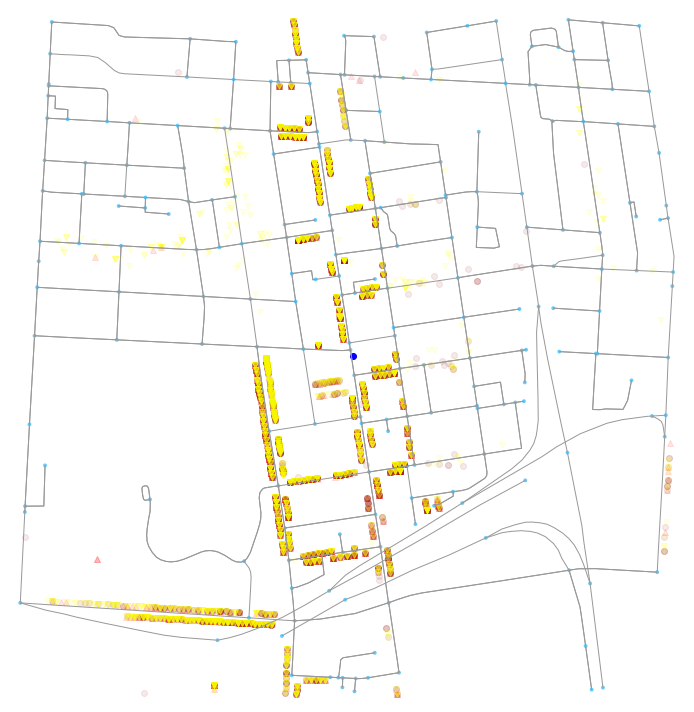

In [330]:
fig, ax = ox.plot_graph(G1, fig_height=10, show=False, close=False)
# ax.scatter(violations_x_meters['long_combined'], violations_x_meters['lat_combined'], alpha=0.2, c='red')

# ax.scatter(midday_violations['long_combined'], midday_violations['lat_combined'], alpha=0.1, c='green', marker="o")
ax.scatter(morning_violations['long_combined'], morning_violations['lat_combined'], alpha=0.1, c='red', marker="^")
ax.scatter(afternoon_violations['long_combined'], afternoon_violations['lat_combined'], alpha=0.1, c='brown')
ax.scatter(evening_violations['long_combined'], evening_violations['lat_combined'], alpha=0.1, c='yellow', marker="v")
# ax.scatter(night_violations['long_combined'], night_violations['lat_combined'], alpha=0.4, c='gray')

ax.scatter([-83.003500], [39.977110], c='blue')
plt.tight_layout()


### Hot meters -- meters that got most expensive tickets

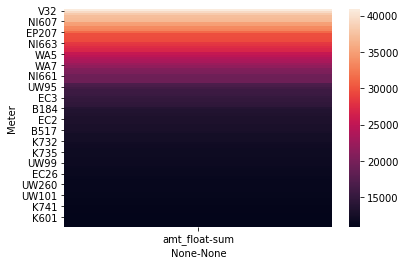

In [331]:
grp = violations_x_meters[['Meter', 'amt_float']].dropna() \
    .groupby(['Meter'], as_index=False) \
    .agg(['sum']) \
    .sort_values([('amt_float', 'sum')], ascending=False) \
    .head(100)
sns.heatmap(grp)

In [332]:
hot_meter_numbers = pd.Series(grp.index)
hot_meters = short_north_violations[violations_x_meters['Meter'].isin(hot_meter_numbers)]

/Users/ovi/Library/Caches/pypoetry/virtualenvs/cmh-packing-violations-80a-bCP1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [333]:
# plot the route with folium
route_map = ox.plot_graph_folium(G1, popup_attribute='name', edge_width=2)

import folium

folium.Marker(
    location=[39.977110, -83.003500],
    popup='The Forge',
    icon=folium.Icon(icon='glyphicon-scale', prefix='glyphicon')
).add_to(route_map)

hot_meters.apply(lambda row: \
                     folium.Marker(
                         location=[row['lat_combined'], row['long_combined']],
                         popup=grp.loc[row['Meter']][('amt_float', 'sum')],
                         icon=folium.Icon(icon='scale', color='darkgreen')
                     ).add_to(route_map),
                 axis=1)

# save to disk
filepath = 'data/graph.html'
route_map.save(filepath)

In [334]:
from IPython.display import IFrame

In [335]:
IFrame(filepath, width=600, height=700)